# Training scDGD
## An example on the 10x mouse brain 5k data set



### imports and installations

In [2]:
import torch
import numpy as np
!pip install anndata
import anndata as ad
!pip install scanpy
import scanpy as sc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 8.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=4f9cba5ed65c65aba3c85971aa18c976484ac75b48771172120d7425db4e3cc9
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created whee

In [3]:
# install scDGD from the repository
!pip install git+https://github.com/Center-for-Health-Data-Science/scDGD
from scDGD.classes import GaussianMixture
from scDGD.models import DGD
from scDGD.functions import prepate_data, dgd_train

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Center-for-Health-Data-Science/scDGD to /tmp/pip-req-build-1t1yop4a
  Running command git clone --filter=blob:none --quiet https://github.com/Center-for-Health-Data-Science/scDGD /tmp/pip-req-build-1t1yop4a
  Resolved https://github.com/Center-for-Health-Data-Science/scDGD to commit e00f1f19bc7a4afbb2d77b9f6aa128e06293a303
  Preparing metadata (setup.py) ... done
  Created wheel for scDGD: filename=scDGD-0.2-py3-none-any.whl size=15941 sha256=e1f50d4e3727c3b6abbab2df4c9262fb3d0744e89946a430143b381f9fdfec95
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6vnzo29/wheels/7e/a0/77/dcd9aa6f7d6583e398fdd285d9db298574ef559c04df050771
Successfully built scDGD


### Hyperparameters

In [4]:
###
# define desired hyperparameters
###
latent_dim = 20
n_epochs = 500

# define which feature should be observed in clustering (e.g. cell type or disease state)
adata_label_column_name = 'cell_type'

## Prepare the data

In [5]:
# load the example anndata file
data_path = './data/'
!wget -P data https://zenodo.org/record/7993711/files/adata.h5ad
adata = ad.read(data_path+'adata.h5ad')

--2023-06-01 10:08:07--  https://zenodo.org/record/7993711/files/adata.h5ad
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267996169 (256M) [application/octet-stream]
Saving to: ‘data/adata.h5ad’

adata.h5ad          100%[===================>] 255.58M  1.49MB/s    in 2m 45s  

2023-06-01 10:10:54 (1.55 MB/s) - ‘data/adata.h5ad’ saved [267996169/267996169]



/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# prepare the data for training (and testing)
adata, trainloader, validationloader, testloader = prepate_data(
    adata,
    label_column=adata_label_column_name
)

In [13]:
# get the number of unique cell types as an initial guess for the number of clusters
labels = trainloader.dataset.get_labels()
n_celltypes = len(np.unique(labels))
print('we have {} cells, {} features and {} distinct cell types in this data'.format(adata.shape[0], adata.shape[1], n_celltypes))

we have 7377 cells, 32285 features and 7 distinct cell types in this data


## Set up the model

In [14]:
gmm = GaussianMixture(Nmix=n_celltypes, dim=latent_dim)
model = DGD(out=trainloader.dataset.n_genes, latent=latent_dim)

## Train

In [15]:
# for running in the notebook, you can analyze the performance based on the returned history dataframe

model, rep, test_rep, gmm, history = dgd_train(
    model, gmm, trainloader, validationloader, n_epochs=n_epochs,
    export_dir='./', export_name='scDGD'
)

# but it can also be run with logging to wandb (https://wandb.ai/) for more better monitoring and good project organization
'''
wandb.init(id=id, project="project_name", entity="your_userID")
wandb.run.name = "model_name"
wandb.run.save()

model, rep, test_rep, gmm, history = dgd_train(
    model, gmm, trainloader, validationloader, n_epochs=n_epochs,
    export_dir='./', export_name='scDGD',
    wandb_logging=True
)
'''

epoch 0: train loss 8.081503086508935, validation loss 7.567142568746425, cluster accuracy 0.8268090154211151
model saved at epoch 0 for having so far highest accuracy of 0.8268090154211151
epoch 10: train loss 0.21962437988739245, validation loss 0.2163362916152005, cluster accuracy 0.7008981528554482
epoch 20: train loss 0.21912317620316815, validation loss 0.2157979795881279, cluster accuracy 0.6214200982884257
epoch 30: train loss 0.2186525695092746, validation loss 0.21595358999896333, cluster accuracy 0.5034739874597526
epoch 40: train loss 0.21829653047645609, validation loss 0.21497421130320954, cluster accuracy 0.47568208778173193
epoch 50: train loss 0.21793867497403135, validation loss 0.21506065453638895, cluster accuracy 0.4261989493306219
epoch 60: train loss 0.2162271052164283, validation loss 0.2131930672915216, cluster accuracy 0.37451279444162006
epoch 70: train loss 0.2110419393749513, validation loss 0.20786862160475406, cluster accuracy 0.25995593967124214
epoch 80

'\nwandb.init(id=id, project="project_name", entity="your_userID")\nwandb.run.name = "model_name"\nwandb.run.save()\n\nmodel, rep, test_rep, gmm, history = dgd_train(\n    model, gmm, trainloader, validationloader, n_epochs=n_epochs,\n    export_dir=\'./\', export_name=\'scDGD\',\n    wandb_logging=True\n)\n'

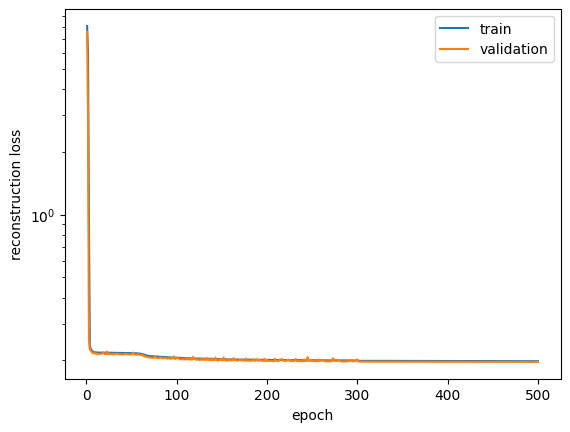

In [19]:
# plot reconstruction losses

import matplotlib.pyplot as plt

plt.plot(history['epoch'], history['train_recon_loss'], label='train')
plt.plot(history['epoch'], history['test_recon_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('reconstruction loss')
plt.yscale('log')
plt.legend()
plt.show()

## Downstream use

The learned representation can be added to the anndata object and then one can continue as usual with scanpy tools like UMAP visualizations.

In [17]:
# you can add the representation to the anndata object
# and then continue as usual with scanpy visualization and analysis

adata_train = adata.copy()[adata.obs['train_val_test']=='train']
adata_train.obsm['Latent'] = rep.z.detach().cpu().numpy()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


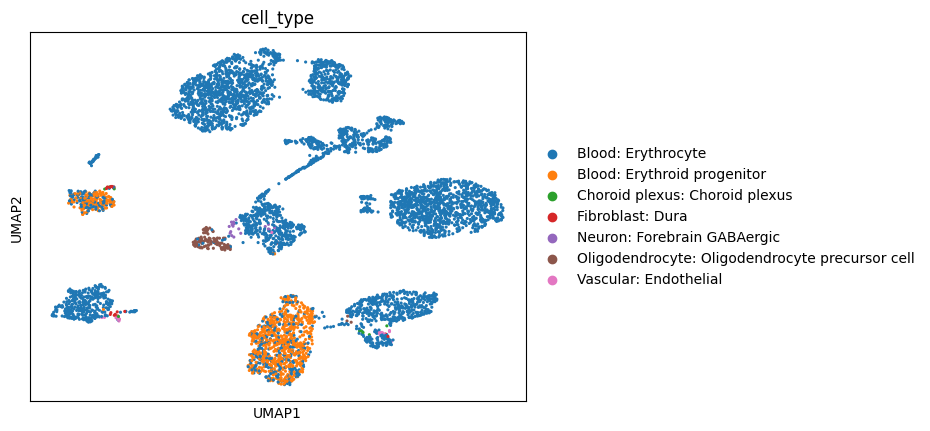

In [18]:
# plot a scanpy umap of the latent space colored by cell type
sc.pp.neighbors(adata_train, use_rep='Latent')
sc.tl.umap(adata_train)
sc.pl.umap(adata_train, color=adata_label_column_name)